In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")


# standard
import json, pickle
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import median
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as ticker
from itertools import combinations
from scipy import stats
import math
from matplotlib.ticker import FormatStrFormatter

# my lib
import PPILinkPred as pred
import genData_helper as helper
import traversalHelper as tr

In [2]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return h

In [3]:
def standardize_plots_old(precsList, recsList, decimalPt):
    # note that the rec is trimmed in favor of the smallest rec (both min max)
    # corr recList to decimal pt -> create a rec list with minimum unit interval
    # -> map prec of each list to the rec list position, dont exists then np.nan -> use pandas interpolate
    corrStr = "{0:."+str(decimalPt)+"f}"
    tmp = []
    for recs in recsList: tmp.append(np.asarray([float(corrStr.format(rec)) for rec in recs]))
    recsList = tmp.copy()
    flattenRecs = np.asarray(recsList).flatten()
    minBoundRec, maxBoundRec = max([recs[0] for recs in recsList]), min([recs[-1] for recs in recsList])
    baseRecs = np.asarray([i for i in range(int(minBoundRec*(10**decimalPt)), int(maxBoundRec*(10**decimalPt)))])/10**decimalPt
    alignedPrecsList = []
    for i in range(len(precsList)):
        precsMap = {}
        for k in baseRecs: precsMap[k] = np.nan
        for j in range(len(precsList[i])):
            if recsList[i][j] in precsMap: precsMap[recsList[i][j]] = precsList[i][j]
        mappedPrecs = pd.Series(list(precsMap.values()))
        alignedPrecsList.append(list(np.asarray(mappedPrecs.interpolate(limit_direction='both'))))
    return alignedPrecsList, baseRecs

def standardize_plots(prec, rec, decimalPt=5):
    std_rec = [float(i/10**decimalPt) for i in range(
        0, int(min([r[-1] for r in rec])*(10**decimalPt)))] # std rec
    corrStr = "{0:."+str(decimalPt)+"f}" # corr rec
    tmp = []
    for r in rec: tmp.append(np.asarray([float(corrStr.format(j)) for j in r]))
    rec = tmp.copy()
    fittedPrec = [] # map prec with n intervals
    for j in range(len(prec)):
        precsMap = {}
        for k in std_rec: precsMap[k] = np.nan
        for k in range(len(prec[j])):
            if rec[j][k] in precsMap: precsMap[rec[j][k]] = prec[j][k]
        mappedPrecs = pd.Series(list(precsMap.values()))
        fittedPrec.append(list(mappedPrecs.interpolate(limit_direction='both')))
    return fittedPrec, std_rec

def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

# init metadata

In [4]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E_f1Alt": "navy",
    "L3E_f2Alt": "gold",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey",
    "countP4": "black"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no.\n of $P_{4}$", "L3N'\n($f_{1}$)", "L3N'\n($f_{2}$)", "L3N\n($f_{1}$)", "L3N\n($f_{2}$)"]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no. of $P_{4}$", "L3N'($f_{1}$)", "L3N'($f_{2}$)", "L3N($f_{1}$)", "L3N($f_{2}$)"]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# read data into df

In [32]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

#methods = ["L3E1_f1", "L3E_f1Alt", "L3E_f2Alt", "L3E1_f2"]
#ds_names = ['bioGRID', 'STRING', 'MINT']
methods = ["commonNeighbor", "L3Normalizing", "CRA", "CH2_L3", "Sim", 'random', "L3E1_f1", "L3E1_f2"]
ds_names = ['bioGRID', 'STRING', 'MINT']
ds_names = [ds+"_contam{}Percent".format(salt) for ds in ds_names for salt in [5,10,15,20,25]]

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(0,10):
            precRec = {}
            with open("./precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']
                
df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,CN,bioGRID_contam5Percent,0,0.000000,0.000000
1,50,1,CN,bioGRID_contam5Percent,0,0.500000,0.000016
2,50,2,CN,bioGRID_contam5Percent,0,0.666667,0.000032
3,50,3,CN,bioGRID_contam5Percent,0,0.500000,0.000032
4,50,4,CN,bioGRID_contam5Percent,0,0.600000,0.000048
...,...,...,...,...,...,...,...
44912155,50,8456,L3E1_f2,MINT_contam25Percent,9,0.081116,0.054033
44912156,50,8457,L3E1_f2,MINT_contam25Percent,9,0.081107,0.054033
44912157,50,8458,L3E1_f2,MINT_contam25Percent,9,0.081097,0.054033
44912158,50,8459,L3E1_f2,MINT_contam25Percent,9,0.081087,0.054033


In [7]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

methods = ["L3E1_f1", "L3E_f1Alt", "L3E_f2Alt", "L3E1_f2"]
ds_names = ['bioGRID', 'STRING', 'MINT']
#methods = ["commonNeighbor", "L3Normalizing", "CRA", "CH2_L3", "Sim", 'random', "L3E1_f1", "L3E1_f2"]
#ds_names = ['bioGRID_5FoldCV', 'STRING_5FoldCV', 'MINT_5FoldCV'] # means have self PPIs lol

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(5):
            precRec = {}
            with open("./precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']
                
df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,L3E1_f1,bioGRID,0,1.000000,0.000018
1,50,1,L3E1_f1,bioGRID,0,1.000000,0.000035
2,50,2,L3E1_f1,bioGRID,0,1.000000,0.000053
3,50,3,L3E1_f1,bioGRID,0,1.000000,0.000071
4,50,4,L3E1_f1,bioGRID,0,1.000000,0.000088
...,...,...,...,...,...,...,...
2245635,50,8457,L3E1_f2,MINT,4,0.238354,0.238185
2245636,50,8458,L3E1_f2,MINT,4,0.238326,0.238185
2245637,50,8459,L3E1_f2,MINT,4,0.238416,0.238303
2245638,50,8460,L3E1_f2,MINT,4,0.238388,0.238303


In [5]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]
ds_names = ['bioGRID', 'STRING', 'MINT']

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(0,10):
            precRec = {}
            with open("./precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']

for randSz in range(60, 100, 10):
    for ds in ds_names:
        for method in methods:
            for i in range(0,10):
                precRec = {}
                with open("./precision_recall_out/{}_{}_randSz{}_topPPI_{}.json".format(method, ds, randSz, i), "r") as f:
                    precRec = json.loads(f.read())

                    df["randSz"] += [randSz for j in range(len(precRec['prec']))]
                    df["rank"] += [j for j in range(len(precRec['prec']))]
                    df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                    df['ds'] += [ds for j in range(len(precRec['prec']))]
                    df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                    df['prec'] += precRec['prec']
                    df['rec'] += precRec['rec']
                
df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,CN,bioGRID,0,1.0,0.000018
1,50,1,CN,bioGRID,0,1.0,0.000035
2,50,2,CN,bioGRID,0,1.0,0.000053
3,50,3,CN,bioGRID,0,1.0,0.000071
4,50,4,CN,bioGRID,0,1.0,0.000088
...,...,...,...,...,...,...,...
26946715,90,1686,rand,MINT,9,0.0,0.000000
26946716,90,1687,rand,MINT,9,0.0,0.000000
26946717,90,1688,rand,MINT,9,0.0,0.000000
26946718,90,1689,rand,MINT,9,0.0,0.000000


In [124]:
# neglecting L3E(f1) and L3E(f2) and parsing separately when needed
df.to_pickle("./precision_recall_out/full_df.pkl")

In [5]:
df = pd.read_pickle("./precision_recall_out/full_df.pkl")

# AUC of precision-recall, ranked from low to high

In [8]:
auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]

for randSz in range(50, 91, 10):
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))
            

sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 91, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{50: {'MINT': {'rand': 2.247122680139217e-06, 'CRA': 0.06300664211614702, 'CN': 0.06752841563913219, 'Sim': 0.10199408449364074, 'L3E1_f2': 0.11202714492530083, 'CH2': 0.12321230294881391, 'L3': 0.13076471346062984, 'L3E1_f1': 0.1391037737179351}, 'bioGRID': {'rand': 7.582320640920637e-06, 'CN': 0.059105628753706105, 'Sim': 0.06698495593962117, 'CRA': 0.0935578609311186, 'L3': 0.10286552643626798, 'L3E1_f2': 0.10837767858420036, 'CH2': 0.11118983825094655, 'L3E1_f1': 0.14104255973992252}, 'STRING': {'rand': 2.4938190694241533e-05, 'CH2': 0.2841731521655968, 'Sim': 0.3129469819403806, 'L3': 0.3274289671072244, 'L3E1_f2': 0.3517995098143162, 'CN': 0.361281961850816, 'L3E1_f1': 0.39032348955829466, 'CRA': 0.43662115292900044}}, 60: {'MINT': {'rand': 1.0088772186827765e-06, 'CN': 0.07428633081786082, 'CRA': 0.09135334412507298, 'Sim': 0.09649401615181949, 'L3E1_f2': 0.11354228984177075, 'CH2': 0.11602928720478811, 'L3': 0.12498516118340808, 'L3E1_f1': 0.13862589217061086}, 'bioGRID': {'ran

In [8]:
auc_map = {}
#methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
methods = ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]

for randSz in range(50, 51, 10):
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))
            

sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 51, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{50: {'bioGRID': {'L3E_f2Alt': 0.10485166961839765, 'L3E1_f2': 0.10951911245558824, 'L3E_f1Alt': 0.13805688293429116, 'L3E1_f1': 0.1420910489403931}, 'STRING': {'L3E1_f2': 0.35143115047684553, 'L3E_f2Alt': 0.35414191915453747, 'L3E1_f1': 0.3902211947400476, 'L3E_f1Alt': 0.39721655583771687}, 'MINT': {'L3E_f2Alt': 0.10390019249062035, 'L3E1_f2': 0.11166097057275834, 'L3E_f1Alt': 0.13509096028373718, 'L3E1_f1': 0.1387896906216067}}}


In [39]:
auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
#methods = ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]

for randSz in range(50, 51, 10):
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))
            

sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 51, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{50: {'STRING_contam5Percent': {'rand': 2.2950210123851572e-05, 'CH2': 0.2799458660218107, 'Sim': 0.30902529539465495, 'L3': 0.3223688277678357, 'L3E1_f2': 0.3412859433399421, 'CN': 0.35748993890080094, 'L3E1_f1': 0.37474165465846065, 'CRA': 0.42273640642139687}, 'STRING_contam10Percent': {'rand': 2.54385273548525e-05, 'CH2': 0.27962641892595563, 'Sim': 0.30690595645941876, 'L3': 0.3192877045794987, 'L3E1_f2': 0.3342950914619275, 'CN': 0.353786484362621, 'L3E1_f1': 0.3628590088878686, 'CRA': 0.4079710142508458}, 'bioGRID_contam20Percent': {'rand': 9.318459615101449e-06, 'CRA': 0.04134834730177621, 'CN': 0.05332909762463387, 'Sim': 0.08881236291329053, 'L3': 0.10805005134046256, 'CH2': 0.11329219708485767, 'L3E1_f2': 0.11417840945455615, 'L3E1_f1': 0.13150969242398874}, 'STRING_contam15Percent': {'rand': 2.563485603403452e-05, 'CH2': 0.27769444251701964, 'Sim': 0.3031158240230853, 'L3': 0.31362741504528346, 'L3E1_f2': 0.32507179189164254, 'CN': 0.3450007716897238, 'L3E1_f1': 0.349087066

In [19]:
with open("./precision_recall_out/auc_contam.pkl", "wb") as f:
    pickle.dump(auc_map, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("./precision_recall_out/mean_auc_contam.pkl", "wb") as f:
    pickle.dump(sorted_mean_auc, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("./precision_recall_out/auc_err_contam.pkl", "wb") as f:
    pickle.dump(err_auc, f, protocol=pickle.HIGHEST_PROTOCOL)

In [90]:
sorted_mean_auc, err_auc, auc_map = {}, {}, {}
with open("./precision_recall_out/auc_contam.pkl", "rb") as f:
    auc_map = pickle.load(f)
with open("./precision_recall_out/mean_auc_contam.pkl", "rb") as f:
    sorted_mean_auc = pickle.load(f)
with open("./precision_recall_out/auc_err_contam.pkl", "rb") as f:
    err_auc = pickle.load(f)

In [35]:
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID Yeast', 'STRING Yeast', 'MINT Yeast']

for i in range(len(dss)):
    ds = dss[i]
    buildStr = ""
    for contam in range(5, 26, 5):
        aucVal = np.format_float_scientific(
            np.float32(sorted_mean_auc[50][ds+"_contam{}Percent".format(contam)]['rand']), precision=3)
        buildStr += " & "+str(aucVal)
    print("\\cellcolor{gray!15} "+dsNames[i]+" "+buildStr+" \\\\ \\hline")

\cellcolor{gray!15} BioGRID Yeast  & 7.018e-06 & 7.537e-06 & 7.641e-06 & 9.318e-06 & 8.749e-06 \\ \hline
\cellcolor{gray!15} STRING Yeast  & 2.295e-05 & 2.544e-05 & 2.563e-05 & 2.720e-05 & 3.049e-05 \\ \hline
\cellcolor{gray!15} MINT Yeast  & 1.750e-06 & 1.61e-06 & 1.996e-06 & 2.221e-06 & 1.789e-06 \\ \hline


In [23]:
# the decreasing AUC of rand
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID Yeast', 'STRING Yeast', 'MINT Yeast']

for i in range(len(dss)):
    ds = dss[i]
    buildStr = ""
    for randSz in range(50, 100, 10):
        aucVal = np.format_float_scientific(np.float32(sorted_mean_auc[randSz][ds]['rand']), precision=3)
        buildStr += " & "+str(aucVal)
    print("\\cellcolor{gray!15} "+dsNames[i]+" "+buildStr+" \\\\ \\hline")

\cellcolor{gray!15} BioGRID Yeast  & 7.582e-06 & 4.726e-06 & 2.267e-06 & 1.262e-06 & 3.027e-07 \\ \hline
\cellcolor{gray!15} STRING Yeast  & 2.494e-05 & 1.529e-05 & 8.408e-06 & 3.908e-06 & 9.452e-07 \\ \hline
\cellcolor{gray!15} MINT Yeast  & 2.247e-06 & 1.009e-06 & 5.536e-07 & 4.933e-07 & 0.e+00 \\ \hline


# p-value of PR AUC

In [27]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'CRA'], ['L3E1_f1', 'CRA']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {}: {}".format(pairs[i][0], pairs[i][1], pVal))

L3E1_f1 L3E1_f2: 6.417369028297781e-07
L3E1_f1 CRA: 1.3937570757931329e-09
L3E1_f1 CRA: 0.10389740624538449


In [17]:
# p val
# sample to do: top 2 both to third, between top 2
dss = ['bioGRID_noSelf']
pairs = [['L3E1_f1', 'L3E1_f2']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {}: {}".format(pairs[i][0], pairs[i][1], pVal))

L3E1_f1 L3E1_f2: 1.2530492610194127e-16


In [11]:
pairs = {
    60: [['L3E1_f2', 'L3E1_f1'], ['CRA', 'L3E1_f1'], ['L3E1_f1', 'L3']],
    70: [['L3E1_f1', 'CRA'], ['CRA', 'L3E1_f1'], ['L3E1_f1', 'L3']],
    80: [['L3E1_f2', 'L3E1_f1'], ['CRA', 'L3E1_f1'], ['CRA', 'L3E1_f1']],
    90: [['L3E1_f1', 'L3E1_f2'], ['CRA', 'L3E1_f1'], ['CRA', 'L3E1_f1']]
}
dss = ['bioGRID', 'STRING', 'MINT']
for randSz in range(60, 100, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        pair = pairs[randSz][i]
        pop1 = auc_map[randSz][ds][pair[0]]
        pop2 = auc_map[randSz][ds][pair[1]]
        pVal = stats.ttest_ind(pop1, pop2)[1]
        print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

60
bioGRID L3E1_f2 L3E1_f1: 4.6536085005152854e-17
STRING CRA L3E1_f1: 3.939934347738852e-19
MINT L3E1_f1 L3: 2.4786423889691935e-08
70
bioGRID L3E1_f1 CRA: 9.718391246120536e-15
STRING CRA L3E1_f1: 1.3504634874519485e-18
MINT L3E1_f1 L3: 1.246711376530459e-06
80
bioGRID L3E1_f2 L3E1_f1: 1.83324813986452e-05
STRING CRA L3E1_f1: 1.3110721875796383e-15
MINT CRA L3E1_f1: 0.013131585256036093
90
bioGRID L3E1_f1 L3E1_f2: 0.0019572289134463274
STRING CRA L3E1_f1: 1.3178335086740008e-13
MINT CRA L3E1_f1: 0.7873819683160069


In [12]:
# every p val to rand
# sample to do: top 2 both to third, between top 2
for randSz in range(50, 100, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        for pair in [['rand', x] for x in ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]]:
            pop1 = auc_map[randSz][ds][pair[0]]
            pop2 = auc_map[randSz][ds][pair[1]]
            pVal = stats.ttest_ind(pop1, pop2)[1]
            print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

50
bioGRID rand CN: 4.093831730637693e-27
bioGRID rand CRA: 1.2322965679347075e-29
bioGRID rand L3: 1.431567295070378e-34
bioGRID rand CH2: 2.986364831511628e-34
bioGRID rand Sim: 3.5579908855942085e-26
bioGRID rand L3E1_f1: 1.4494862637043889e-31
bioGRID rand L3E1_f2: 5.066611799175532e-29
STRING rand CN: 8.841272451692345e-38
STRING rand CRA: 5.466158182515257e-42
STRING rand L3: 5.222799069825857e-37
STRING rand CH2: 1.000925688515644e-33
STRING rand Sim: 2.7373300921008285e-36
STRING rand L3E1_f1: 3.306918052289817e-39
STRING rand L3E1_f2: 2.106167399228267e-36
MINT rand CN: 6.020083636453574e-21
MINT rand CRA: 3.7700714839505714e-25
MINT rand L3: 1.2326465157354476e-28
MINT rand CH2: 1.5069375920536184e-28
MINT rand Sim: 1.530007240604279e-24
MINT rand L3E1_f1: 7.659748528794864e-28
MINT rand L3E1_f2: 2.552396326157304e-26
60
bioGRID rand CN: 1.0751146956559287e-28
bioGRID rand CRA: 2.4265064394100775e-29
bioGRID rand L3: 1.2438190576167137e-34
bioGRID rand CH2: 4.484572006443905e

In [49]:
# the decreasing AUC of rand
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID Yeast', 'STRING Yeast', 'MINT Yeast']
predictors = ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]

for i in range(len(dss)):
    ds = dss[i]
    print("\multicolumn{8}{|l|}{\\textbf{"+dsNames[i]+"}} \\\\ \hline")
    for contam in range(5, 26, 5):
        buildStr = ""
        for predictor in predictors:
            pop1 = auc_map[50][ds+"_contam{}Percent".format(contam)]['rand']
            pop2 = auc_map[50][ds+"_contam{}Percent".format(contam)][predictor]
            aucVal = np.format_float_scientific(
                np.float32(stats.ttest_ind(pop1, pop2)[1]), precision=0)
            buildStr += " & "+"".join(str(aucVal).split("."))
        print("\\cellcolor{gray!15} "+str(contam)+"\% of PPI replaced "+buildStr+" \\\\ \\hline")

\multicolumn{8}{|l|}{\textbf{BioGRID Yeast}} \\ \hline
\cellcolor{gray!15} 5\% of PPI replaced  & 2e-29 & 2e-30 & 5e-37 & 5e-34 & 1e-31 & 4e-35 & 8e-31 \\ \hline
\cellcolor{gray!15} 10\% of PPI replaced  & 5e-29 & 2e-28 & 2e-34 & 1e-34 & 7e-32 & 2e-33 & 8e-33 \\ \hline
\cellcolor{gray!15} 15\% of PPI replaced  & 2e-26 & 2e-26 & 2e-34 & 7e-34 & 2e-38 & 2e-31 & 3e-31 \\ \hline
\cellcolor{gray!15} 20\% of PPI replaced  & 5e-26 & 1e-23 & 1e-36 & 7e-35 & 3e-31 & 2e-35 & 5e-30 \\ \hline
\cellcolor{gray!15} 25\% of PPI replaced  & 8e-28 & 8e-21 & 4e-34 & 1e-31 & 7e-27 & 1e-30 & 8e-28 \\ \hline
\multicolumn{8}{|l|}{\textbf{STRING Yeast}} \\ \hline
\cellcolor{gray!15} 5\% of PPI replaced  & 2e-38 & 5e-40 & 6e-38 & 1e-35 & 1e-37 & 5e-37 & 8e-36 \\ \hline
\cellcolor{gray!15} 10\% of PPI replaced  & 9e-39 & 1e-39 & 3e-40 & 1e-36 & 2e-40 & 2e-39 & 3e-39 \\ \hline
\cellcolor{gray!15} 15\% of PPI replaced  & 3e-37 & 3e-38 & 3e-34 & 8e-33 & 4e-33 & 5e-34 & 3e-32 \\ \hline
\cellcolor{gray!15} 20\% of P

# precision-recall figure

In [8]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
ds_names = ['bioGRID', 'STRING', 'MINT']

for randSz in range(50, 100, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("./precision_recall_out/precRecCurves.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
precRec = {}
#methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
#ds_names = ['bioGRID_5FoldCV', 'STRING_5FoldCV', 'MINT_5FoldCV']
methods = ["L3E1_f1", "L3E_f1Alt", "L3E1_f2", "L3E_f2Alt"]
ds_names = ['bioGRID', 'STRING', 'MINT']

for randSz in range(50, 51, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec

In [ ]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]
ds_names = ['bioGRID_noSelf']

for randSz in range(50, 51, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec

In [93]:
precRec = {}
ds_names = ['bioGRID', 'STRING', 'MINT']
ds_names = [ds+"_contam{}Percent".format(salt) for ds in ds_names for salt in [5,10,15,20,25]]
methods = ["commonNeighbor", "L3Normalizing", "CRA", "CH2_L3", "Sim", 'random', "L3E1_f1", "L3E1_f2"]
methods = [methods_names[i] for i in methods]

for randSz in range(50, 51, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("./precision_recall_out/precRecCurves_contam.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
precRec = {}
with open("./precision_recall_out/precRecCurves_contam.pkl", "rb") as f:
    precRec = pickle.load(f)

In [6]:
precRec = {}
with open("./precision_recall_out/precRecCurves.pkl", "rb") as f:
    precRec = pickle.load(f)

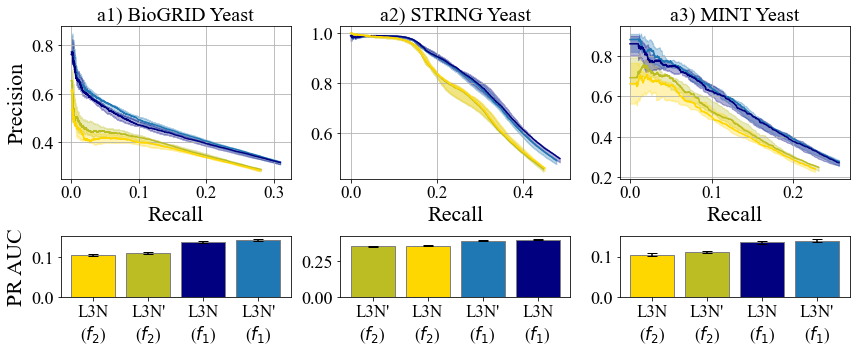

In [13]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 5))
widths = [1,1,1]
heights = [5,2]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]


# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]:
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['lowerPrec']
                , precRec[randSz][ds][method]['upperPrec']
                , facecolor=colors[method], color=colors[method]
                , alpha=0.3)
        ax.plot(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['medianPrec']
                , color=colors[method], label=method)

    ax.set_xlabel("Recall")
    ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))
    ax.grid()
lineAxes[0].set_ylabel("Precision")


# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , yerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("PR AUC")
plt.tight_layout()
plt.savefig("./img_experiments/L3EAlt_PR.png", dpi=300)
plt.show()

In [19]:
dss = ['bioGRID', 'STRING', 'MINT']
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E_f1Alt'], ['L3E1_f1', 'L3E_f1Alt'], ['L3E1_f1', 'L3E_f1Alt']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))
    
pairs = [['L3E1_f2', 'L3E_f2Alt'], ['L3E1_f2', 'L3E_f2Alt'], ['L3E1_f2', 'L3E_f2Alt']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID L3E1_f1 L3E_f1Alt: 0.000736370685154239
STRING L3E1_f1 L3E_f1Alt: 2.697691484213646e-06
MINT L3E1_f1 L3E_f1Alt: 0.020575511647665894
bioGRID L3E1_f2 L3E_f2Alt: 0.00028708938092745286
STRING L3E1_f2 L3E_f2Alt: 0.05864367970950852
MINT L3E1_f2 L3E_f2Alt: 8.363239897272403e-05


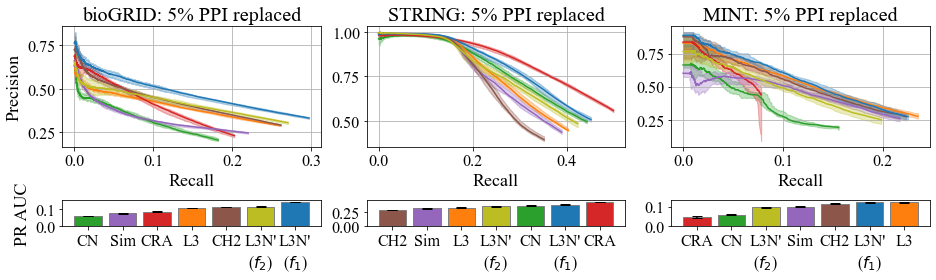

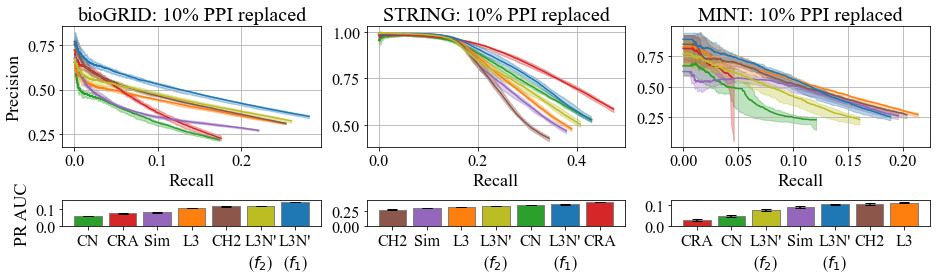

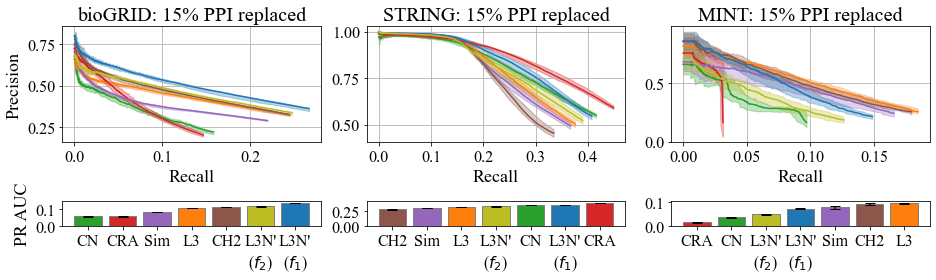

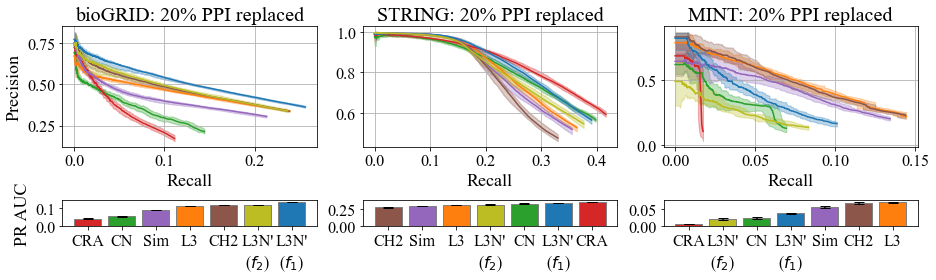

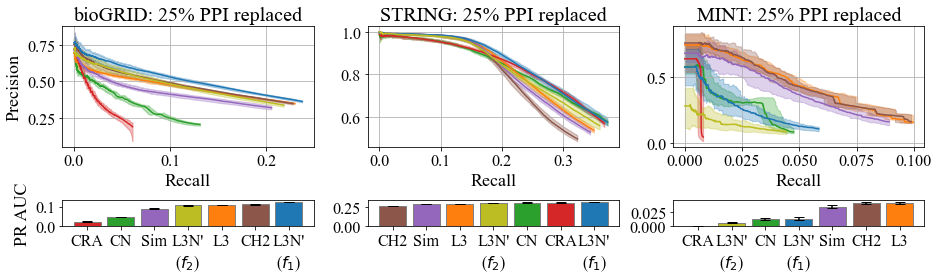

In [103]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
ds_names = ['bioGRID', 'STRING', 'MINT']
dss = [ds+"_contam{}Percent".format(contam) for contam in [5,10,15,20,25] for ds in ds_names]
dsNames = [ds+": {}% PPI replaced".format(contam) for contam in [5,10,15,20,25] for ds in ds_names]
for contamSz in range(int(len(dsNames)/len(ds_names))):
    fig = plt.figure(constrained_layout=True, figsize=(13, 4))
    widths = [1,1,1]
    heights = [6,1.3]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(contamSz*len(ds_names), contamSz*len(ds_names)+len(ds_names)):
        ds = dss[i]
        ax = lineAxes[i-contamSz*len(ds_names)]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title(dsNames[i])
        ax.grid()
        
        ax = barAxes[i-contamSz*len(ds_names)]
        xtick = [k for k in list(sorted_mean_auc[randSz][ds]) if k != 'rand']
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)
        
    lineAxes[0].set_ylabel("Precision")
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/contam pr curves/L3E_yeast_PR_{}.png".format([5,10,15,20,25][contamSz]), dpi=300)
    plt.show()

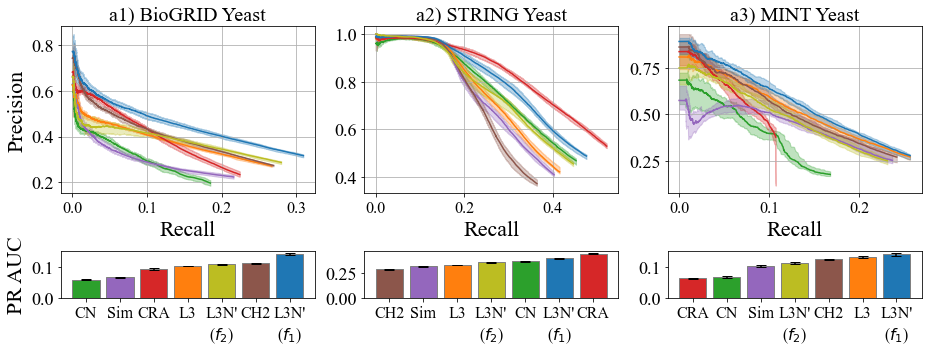

In [70]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
for randSz in range(50, 51, 10):
    fig = plt.figure(constrained_layout=True, figsize=(13, 5))
    widths = [1,1,1]
    heights = [6,1.7]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(len(dss)):
        ds = dss[i]
        ax = lineAxes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))
        ax.grid()
    lineAxes[0].set_ylabel("Precision")


    # barAxes
    for i in range(len(dss)):
        ds = dss[i]
        ax = barAxes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds]) if k != 'rand']
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/L3E_yeast_PR.png", dpi=300)
    plt.show()

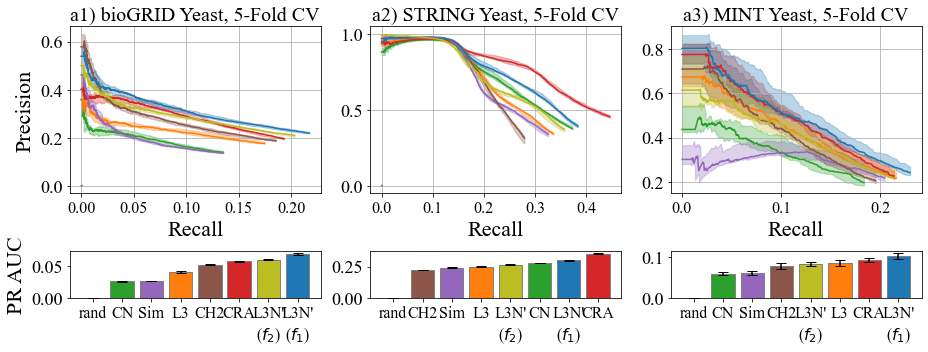

In [28]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID_5FoldCV', 'STRING_5FoldCV', 'MINT_5FoldCV']
dsNames = ['bioGRID', 'STRING', 'MINT']
for randSz in range(50, 51, 10):
    fig = plt.figure(constrained_layout=True, figsize=(13, 5))
    widths = [1,1,1]
    heights = [6,1.7]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(len(dss)):
        ds = dss[i]
        ax = lineAxes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", 'rand']:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title("a{}) {} Yeast, 5-Fold CV".format(i+1, dsNames[i]))
        ax.grid()
    lineAxes[0].set_ylabel("Precision")


    # barAxes
    for i in range(len(dss)):
        ds = dss[i]
        ax = barAxes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/KFold_yeast_PR.png", dpi=300)
    plt.show()

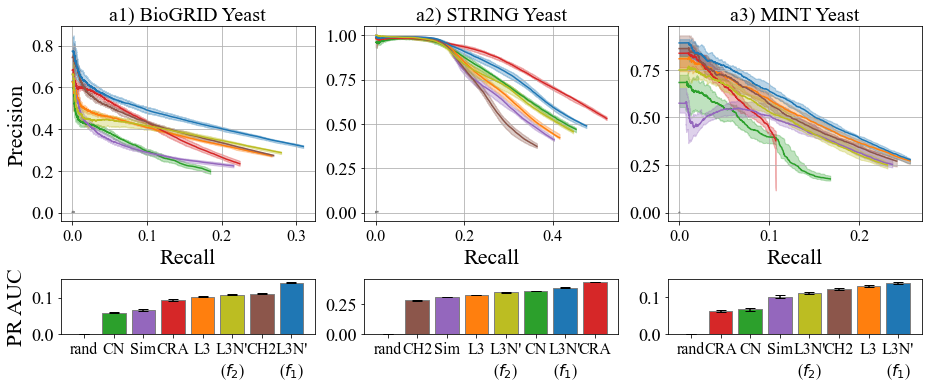

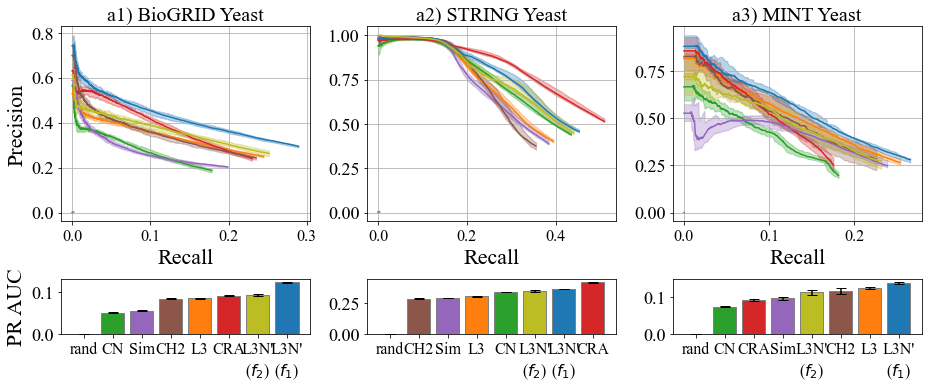

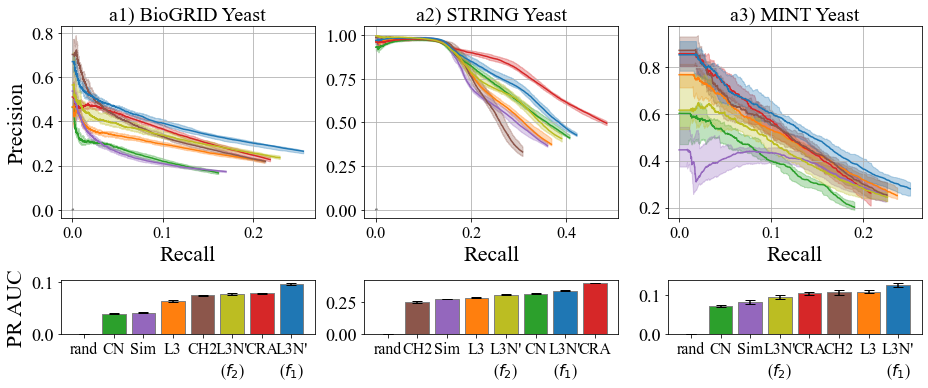

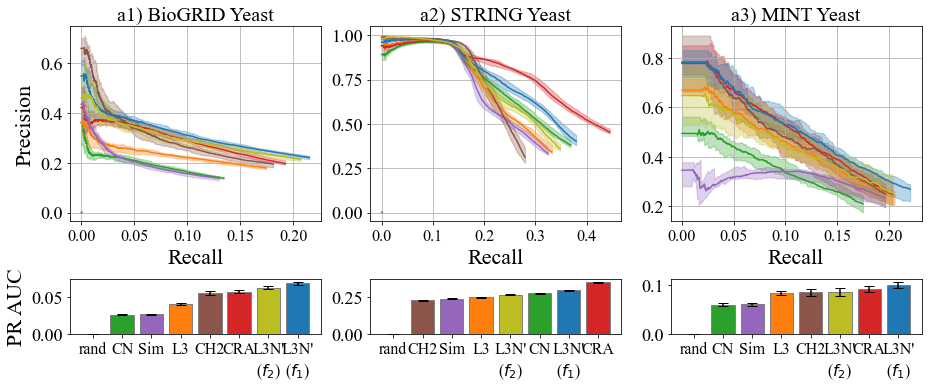

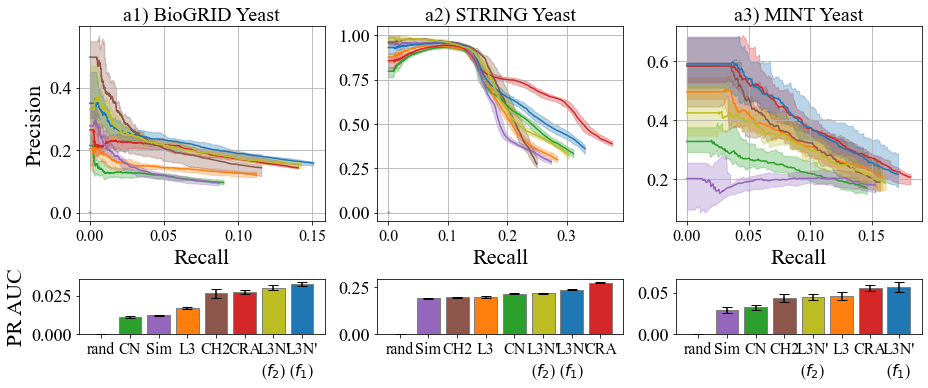

In [15]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
for randSz in range(50, 100, 10):
    fig = plt.figure(constrained_layout=True, figsize=(13, 5.5))
    widths = [1,1,1]
    heights = [6,1.7]
    spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
    barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
    for i in range(len(dss)):
        ds = dss[i]
        ax = lineAxes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['lowerPrec']
                    , precRec[randSz][ds][method]['upperPrec']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)

        ax.set_xlabel("Recall")
        ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))
        ax.grid()
    lineAxes[0].set_ylabel("Precision")


    # barAxes
    for i in range(len(dss)):
        ds = dss[i]
        ax = barAxes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , yerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)
    barAxes[0].set_ylabel("PR AUC")
    plt.tight_layout()
    plt.savefig("./img_experiments/L3E_yeast_PR_randSz{}.png".format(randSz), dpi=300)
    plt.show()

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

randSz = 50
# lineAxes
dss = ['bioGRID_noSelf']
dsNames = ['BioGRID Yeast, with SIPs']
fig = plt.figure(constrained_layout=True, figsize=(5, 5.5))
widths = [1]
heights = [6,1.7]
spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(1)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(1)]
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                        , precRec[randSz][ds][method]['lowerPrec']
                        , precRec[randSz][ds][method]['upperPrec']
                        , facecolor=colors[method], color=colors[method]
                        , alpha=0.3)
        ax.plot(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['medianPrec']
                , color=colors[method], label=method)
    ax.set_xlabel("Recall")
    ax.grid()
    ax.set_title(dsNames[i])
    
    # barAxes
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , yerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
    
lineAxes[0].set_ylabel("Precision")
barAxes[0].set_ylabel("AUC")

plt.tight_layout()
plt.savefig("./img_experiments/bioGRID_SIPs_PRAUC.png", dpi=300)
plt.show()

# PR AUC w.r.t randSz

In [9]:
auc_perRandsz = auc_map.copy()

auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]

for ds in set(df['ds']):
    auc_map[ds] = defaultdict(list)
    for method in methods:
        tmp_df = df[(df['ds'] == ds) & (df['method'] == method)]
        for  trial in range(10):
            auc_map[ds][method].append(metrics.auc([j/100 for j in range(50, 100, 10)],
                                                   [auc_perRandsz[j][ds][method][trial] for j in range(50, 100, 10)]))
            

sorted_mean_auc, err_auc = {}, {}
for ds in auc_map:
    sorted_mean_auc[ds], err_auc[ds] = {}, {}
    for method in auc_map[ds]:
        sorted_mean_auc[ds][method] = np.mean(auc_map[ds][method])
        err_auc[ds][method] = np.std(auc_map[ds][method])
    sorted_mean_auc[ds] = dict(sorted(sorted_mean_auc[ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'MINT': {'CN': 0.025787748015073886, 'Sim': 0.03067565055332012, 'CRA': 0.03489939110903559, 'L3E1_f2': 0.03748873521921791, 'CH2': 0.03929937761131472, 'L3': 0.04074845272994319, 'L3E1_f1': 0.04638184717381413}, 'bioGRID': {'CN': 0.015245259779568041, 'Sim': 0.016364867486228993, 'L3': 0.024912698060739976, 'CH2': 0.02828212331324973, 'CRA': 0.02872887276375608, 'L3E1_f2': 0.03016583275421921, 'L3E1_f1': 0.037426089791133904}, 'STRING': {'CH2': 0.10041632994857648, 'Sim': 0.10575170481610412, 'L3': 0.11013922009951087, 'L3E1_f2': 0.12077799334045872, 'CN': 0.12177640935748073, 'L3E1_f1': 0.13115474947215178, 'CRA': 0.15203226921448637}}


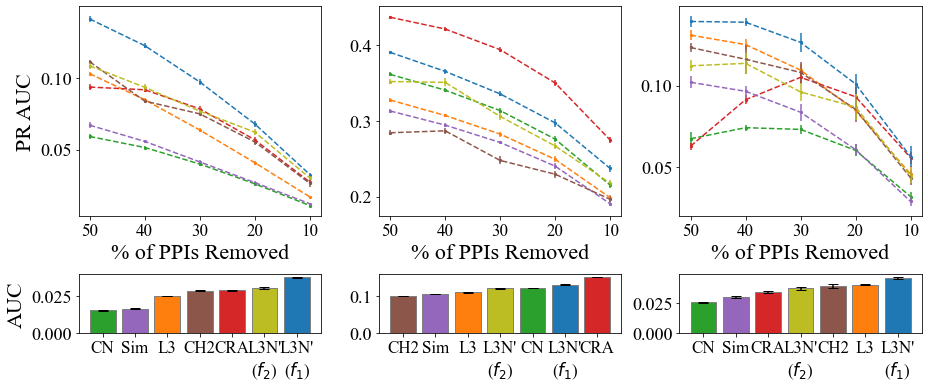

In [10]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
fig = plt.figure(constrained_layout=True, figsize=(13, 5.5))
widths = [1,1,1]
heights = [6,1.7]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([randSz for randSz in range(50, 0, -10)]
                    , [np.mean(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)],
                    fmt='--', color=colors[method],
                    yerr=np.transpose(np.asarray(
                        [np.std(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)]
                    )))
        ax.scatter([randSz for randSz in range(50, 0, -10)],
                   [np.mean(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)],
                   s=5, color=colors[method])
        ax.set_xlabel("% of PPIs Removed")
        ax.set_xticks([randSz for randSz in range(50, 0, -10)])
    ax.set_xlim(ax.get_xlim()[::-1])
lineAxes[0].set_ylabel("PR AUC")


# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[ds][x] for x in xtick]
                      , yerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("AUC")
plt.tight_layout()
plt.savefig("./img_experiments/L3E_yeast_PRAUC.png", dpi=300)
plt.show()

In [14]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'CRA'], ['L3E1_f1', 'L3']]
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[ds][pairs[i][0]]
    pop2 = auc_map[ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID L3E1_f1 L3E1_f2: 1.0794953129363955e-18
STRING L3E1_f1 CRA: 6.4703309888849304e-24
MINT L3E1_f1 L3: 8.114572987556221e-11


# PR AUC w.r.t contamSz

In [74]:
auc_perContamsz = auc_map.copy()

auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]

for ds in ['bioGRID', 'STRING', 'MINT']:
    auc_map[ds] = defaultdict(list)
    for method in methods:
        tmp_df = df[(df['ds'].str.contains(ds)) & (df['method'] == method)]
        for trial in range(10):
            auc_map[ds][method].append(metrics.auc([j/100 for j in range(5, 26, 5)],
                                       [auc_perContamsz[50]["{}_contam{}Percent".format(
                                           ds, contam)][method][trial] for contam in range(5, 26, 5)])
                                      )
            

sorted_mean_auc, err_auc = {}, {}
for ds in auc_map:
    sorted_mean_auc[ds], err_auc[ds] = {}, {}
    for method in auc_map[ds]:
        sorted_mean_auc[ds][method] = np.mean(auc_map[ds][method])
        err_auc[ds][method] = np.std(auc_map[ds][method])
    sorted_mean_auc[ds] = dict(sorted(sorted_mean_auc[ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'bioGRID': {'CN': 0.011279772584239716, 'CRA': 0.011473891304492839, 'Sim': 0.01683209655304676, 'L3': 0.021446535197045122, 'CH2': 0.02266136949200809, 'L3E1_f2': 0.022903954872716757, 'L3E1_f1': 0.027020319104560854}, 'STRING': {'CH2': 0.05545488797034877, 'Sim': 0.060423073965826635, 'L3': 0.06255168570034378, 'L3E1_f2': 0.06500097860470935, 'CN': 0.06837808766686496, 'L3E1_f1': 0.06988511993199756, 'CRA': 0.07603194734570426}, 'MINT': {'CRA': 0.003944880403772274, 'CN': 0.007207103007243884, 'L3E1_f2': 0.009835129079070349, 'L3E1_f1': 0.01399206194377233, 'Sim': 0.014542030726493876, 'CH2': 0.017003746362299607, 'L3': 0.017760393549347588}}


In [91]:
# mean slope
auc_perContamsz = auc_map.copy()
auc_changes = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]

for ds in ['bioGRID', 'STRING', 'MINT']:
    auc_changes[ds] = defaultdict(list)
    for method in methods:
        tmp_df = df[(df['ds'].str.contains(ds)) & (df['method'] == method)]
        aucs = [np.mean(auc_perContamsz[50]["{}_contam{}Percent".format(ds, contam)][method]) for contam in range(5, 26, 5)]
        auc_changes[ds][method] = [(aucs[j]-aucs[j-1])/aucs[j-1] for j in range(1, len(aucs))]
        
sorted_meanChg_auc, err_aucChg = {}, {}
for ds in auc_changes:
    sorted_meanChg_auc[ds], err_aucChg[ds] = {}, {}
    for method in auc_changes[ds]:
        sorted_meanChg_auc[ds][method] = np.mean(auc_changes[ds][method])
        err_aucChg[ds][method] = np.std(auc_changes[ds][method])
    sorted_meanChg_auc[ds] = dict(sorted(sorted_meanChg_auc[ds].items(), key=lambda item: item[1])[::-1])
    
print(sorted_meanChg_auc)

{'bioGRID': {'Sim': 0.04710472903048109, 'L3': 0.00482632498940317, 'CH2': -0.004835922827252408, 'L3E1_f2': -0.019508703817647823, 'L3E1_f1': -0.03415062999774953, 'CN': -0.06047003483235025, 'CRA': -0.26768279068631606}, 'STRING': {'CH2': -0.007649117804860763, 'Sim': -0.015465211976151402, 'L3': -0.019826999787895885, 'L3E1_f2': -0.027213341578991156, 'CN': -0.03257821805636343, 'L3E1_f1': -0.03726589010799502, 'CRA': -0.07163010116007565}, 'MINT': {'CH2': -0.21455066078813234, 'Sim': -0.21897658201811432, 'L3': -0.22614205825492517, 'CN': -0.3054829799089664, 'L3E1_f1': -0.39008270057151495, 'L3E1_f2': -0.45436335511796827, 'CRA': -0.5554592370843044}}


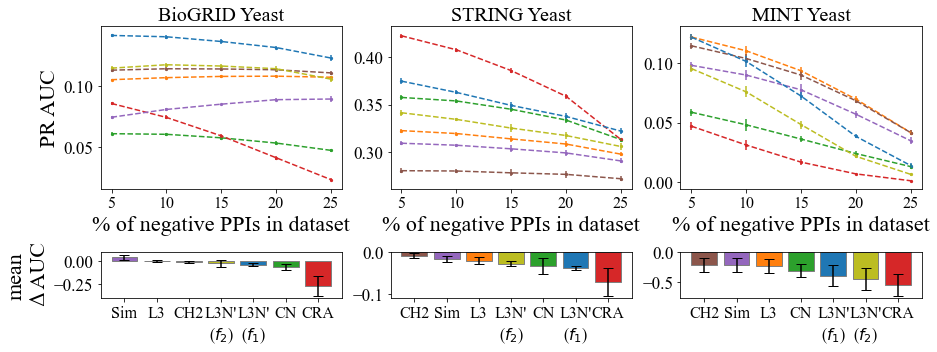

In [92]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=17)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
titles = ['BioGRID Yeast', 'STRING Yeast', 'MINT Yeast']
fig = plt.figure(constrained_layout=True, figsize=(13, 5))
widths = [1,1,1]
heights = [6,1.7]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
#barAxes2 = [fig.add_subplot(spec[2, col]) for col in range(3)]
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([contamSz for contamSz in range(5, 26, 5)]
                    , [np.mean(auc_perContamsz[randSz]["{}_contam{}Percent".format(
                                               ds, contam)][method]) for contam in range(5, 26, 5)],
                    fmt='--', color=colors[method],
                    yerr=np.transpose(np.asarray(
                        [np.std(auc_perContamsz[randSz]["{}_contam{}Percent".format(
                                               ds, contam)][method]) for contam in range(5, 26, 5)]
                    )))
        ax.scatter([contamSz for contamSz in range(5, 26, 5)],
                   [np.mean(auc_perContamsz[randSz]["{}_contam{}Percent".format(
                                               ds, contam)][method]) for contam in range(5, 26, 5)],
                   s=5, color=colors[method])
        ax.set_xlabel("% of negative PPIs in dataset")
        ax.set_xticks([contamSz for contamSz in range(5, 26, 5)])
    #ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_title(titles[i])
lineAxes[0].set_ylabel("PR AUC")


'''
# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[ds][x] for x in xtick]
                      , yerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("AUC")
'''


for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_meanChg_auc[ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_meanChg_auc[ds][x] for x in xtick]
                      , yerr=[err_aucChg[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("mean\n Δ AUC")

plt.tight_layout()
plt.savefig("./img_experiments/L3E_contam_yeast_PRAUC.png", dpi=300)
plt.show()

In [57]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['CH2', 'L3'], ['L3E1_f1', 'CH2'], ['CRA', 'L3E1_f2']]
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_changes[ds][pairs[i][0]]
    pop2 = auc_changes[ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID CH2 L3: 0.29848349611936953
STRING L3E1_f1 CH2: 0.0006456560898020438
MINT CRA L3E1_f2: 0.529796041108317
